1. EDA
a. Correlation Heatmap

In [6]:
# import dataset and libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("cleaned_dataset.csv")

In [7]:
# Convert date columns to datetime format for easier analysis

# BorrowDate is mostly MM/DD/YYYY
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# These are mostly DD/MM/YYYY
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True)
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True)

# These are mostly in YYYY-MM-DD format
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")
df.head()

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/4099672203.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True)
/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/4099672203.py:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True)


,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,...,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,...,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,...,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,...,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,...,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,...,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


In [12]:
# More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.
df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

# A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

# A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

# Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) fron the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

(1565, 24)

Number of defaulters: 133
Percentage of Defaults vs Non-Defaults:
 0    91.501597
1     8.498403
Name: proportion, dtype: float64


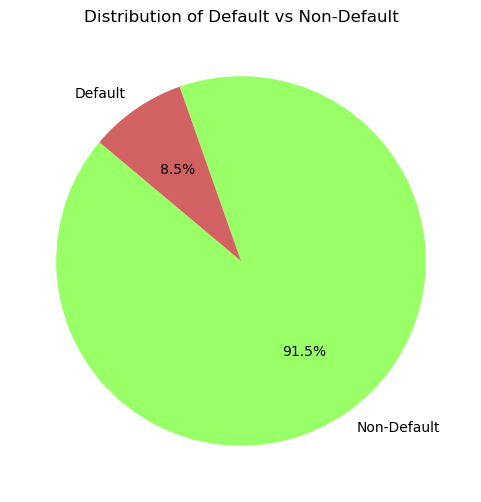

In [40]:
# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)

# Visyalize the distribution of the target variable as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=140, colors=["#99ff66","#d26161"])
plt.title('Distribution of Default vs Non-Default')
plt.show()

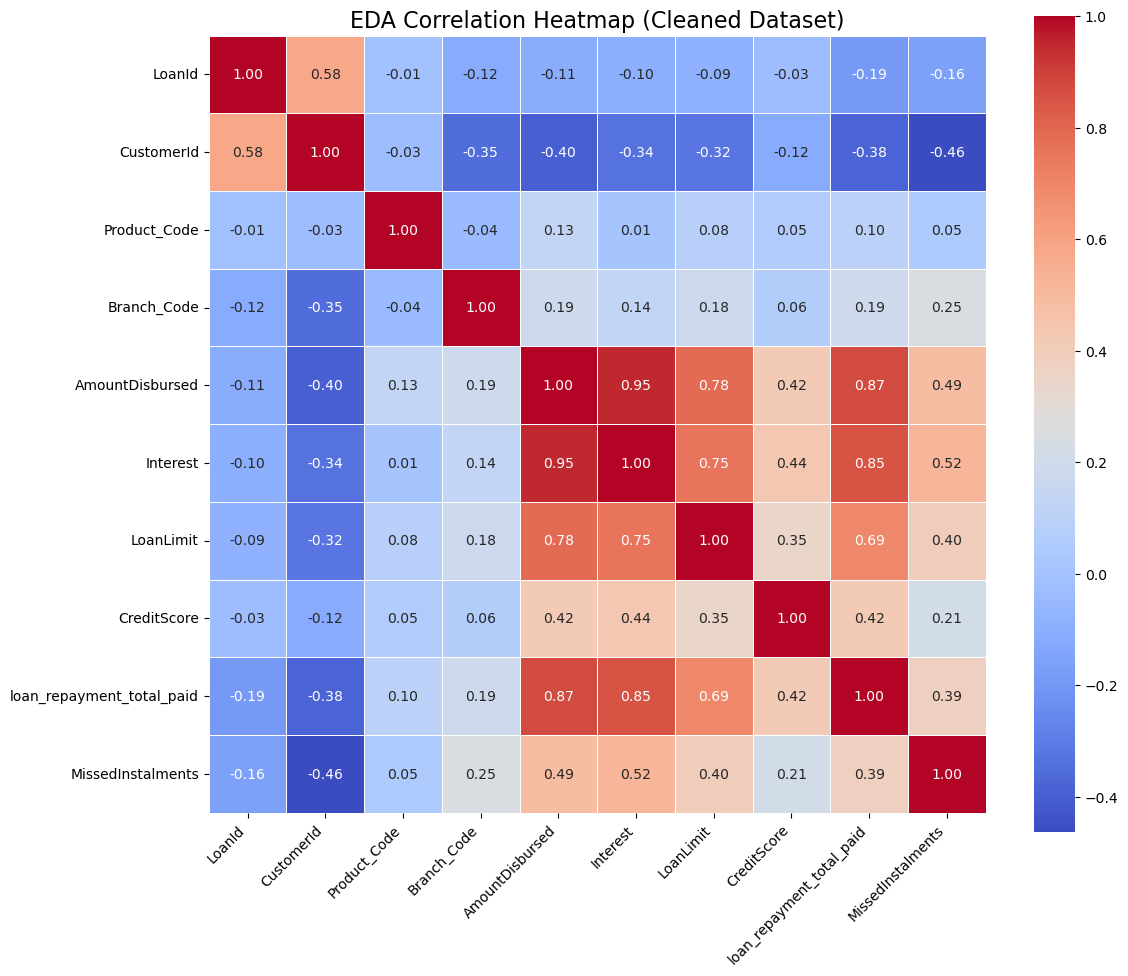

In [14]:
# Convert categorical columns to numerical codes
df['Product_Code'] = df['Product'].astype('category').cat.codes
df['Branch_Code'] = df['Branch'].astype('category').cat.codes

# Columns to include in the heatmap
target_cols = [
    'LoanId', 'CustomerId', 'Product_Code', 'Branch_Code',
    'AmountDisbursed', 'Interest', 'LoanLimit', 'CreditScore',
    'loan_repayment_total_paid', 'MissedInstalments'
]

# Calculate the correlation matrix
corr_matrix = df[target_cols].corr()

# Heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('EDA Correlation Heatmap (Cleaned Dataset)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Print and save the heatmap
plt.savefig('correlation_heatmap_cleaned.png')
plt.show()

B. Categorical Risk Analysis
** Calculate avaerage missed instalments per product
** Can check how many missed instalments they made per product

Purpose : Analyzing product-wise defaults identifies risky terms, ensures cash flow alignment, and provides critical features for AI models to predict and mitigate credit risks effectively.

If 5 weeks missed instalments > 10 weeks missed instalments, there is cash flow mismatch. 

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/2528298025.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


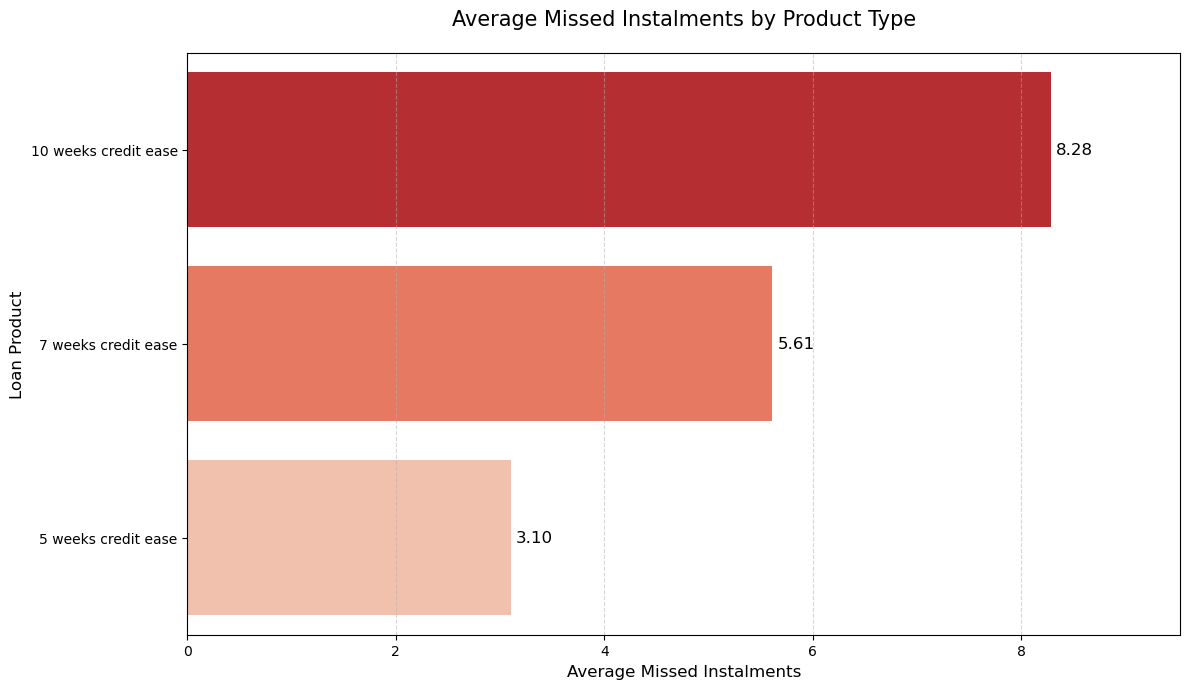

In [ ]:
# Visualization: Average Missed Instalments by product -> to detact Risky clients
product_risk = df.groupby('Product')['MissedInstalments'].mean().sort_values(ascending=False).reset_index()

# Visualization: Bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 0.05,     
            p.get_y() + p.get_height()/2,
            f'{width:.2f}', 
            va='center',    
            fontsize=12, 
            fontweight='regular')

plt.title('Average Missed Instalments by Product Type', fontsize=15, pad=20)
plt.xlabel('Average Missed Instalments', fontsize=12)
plt.ylabel('Loan Product', fontsize=12)

plt.xlim(0, product_risk['MissedInstalments'].max() * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/4028850925.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=product_balance, x='LoanBalance', y='Product', palette='viridis')


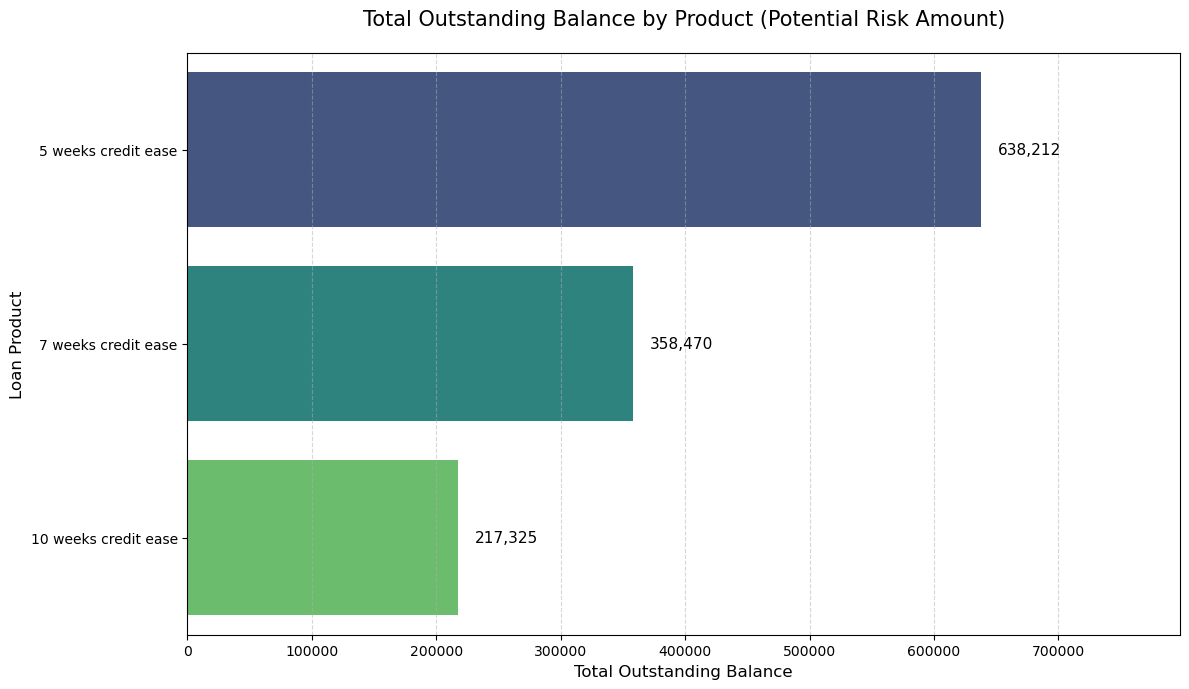

In [29]:
# Visualization: Total Outstanding Balance by product -> to detact Potential Risk Amount
product_balance = df.groupby('Product')['LoanBalance'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=product_balance, x='LoanBalance', y='Product', palette='viridis')

for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + (ax.get_xlim()[1] * 0.02), 
                p.get_y() + p.get_height() / 2,    
                f'{width:,.0f}',                 
                va='center',              
                fontsize=11, 
                fontweight='normal')

plt.title('Total Outstanding Balance by Product (Potential Risk Amount)', fontsize=15, pad=20)
plt.xlabel('Total Outstanding Balance', fontsize=12)
plt.ylabel('Loan Product', fontsize=12)

plt.xlim(0, product_balance['LoanBalance'].max() * 1.25)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/1215590079.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)


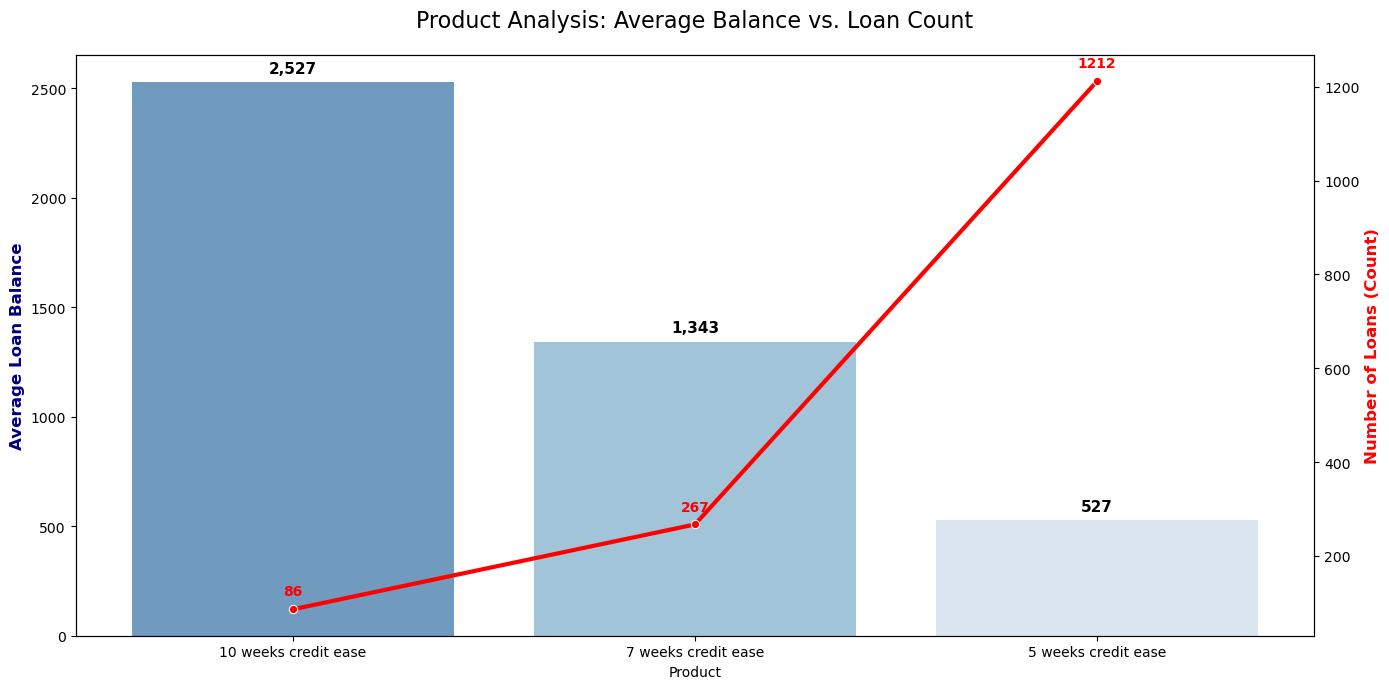

In [ ]:
# Calculate product statistics
product_stats = df.groupby('Product').agg(
    LoanCount=('LoanId', 'count'),
    AvgBalance=('LoanBalance', 'mean')
).sort_values(by='AvgBalance', ascending=False).reset_index()

# Visualization: Average Balance vs. Loan Count by Product
fig, ax1 = plt.subplots(figsize=(14, 7))

# Average Balance (Bar Chart)
sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)
ax1.set_ylabel('Average Loan Balance', fontsize=12, fontweight='bold', color='navy')
ax1.set_title('Product Analysis: Average Balance vs. Loan Count', fontsize=16, pad=20)

# Number labels on top of bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.0f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), 
                 textcoords='offset points', fontsize=11, fontweight='bold')

# number of Loans (Line Chart - Dual Axis)
ax2 = ax1.twinx() 
sns.lineplot(data=product_stats, x='Product', y='LoanCount', color='red', marker='o', linewidth=3, ax=ax2)
ax2.set_ylabel('Number of Loans (Count)', fontsize=12, fontweight='bold', color='red')

# Annotate Loan Count values
for i, txt in enumerate(product_stats['LoanCount']):
    ax2.annotate(txt, (product_stats['Product'][i], product_stats['LoanCount'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

Through above 3 graphs (Average missed instalments, Total outstanding balance by product, Product analysis), AI can read 10 weeks credit ease has high risk to be repaid. Proven less clients borrow high amount of money from company. Hence, company needs regulation only certain credit over client can buy 'certain product'

----------------------------------------------------------------------------------------------------------------------

C. Correlation between Credit score and miss instalments
** lower credit score has high possibility to make missed instalments. (0 to 4,000)
** Why few client who has high credit score made missed instalments? (20,000)

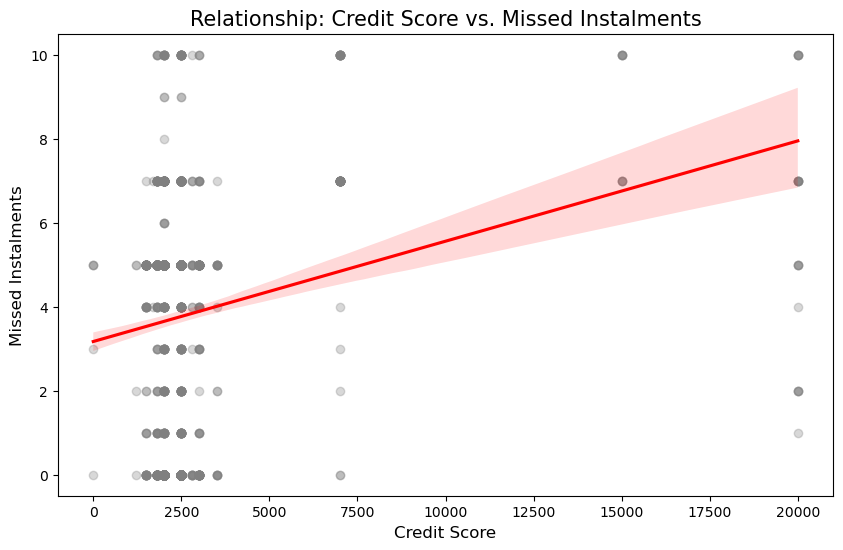

In [31]:
# Visualization: Scatter plot with regression line - Credit Score vs. Missed Instalments
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='CreditScore', y='MissedInstalments', 
            scatter_kws={'alpha':0.3, 'color':'gray'}, line_kws={'color':'red'})

plt.title('Relationship: Credit Score vs. Missed Instalments', fontsize=15)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Missed Instalments', fontsize=12)
plt.show()

** Find out the client details who has high credit score but made missed instalments.

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/1892040045.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=score_risk, x='ScoreRange', y='MissedInstalments', palette='RdYlGn_r')


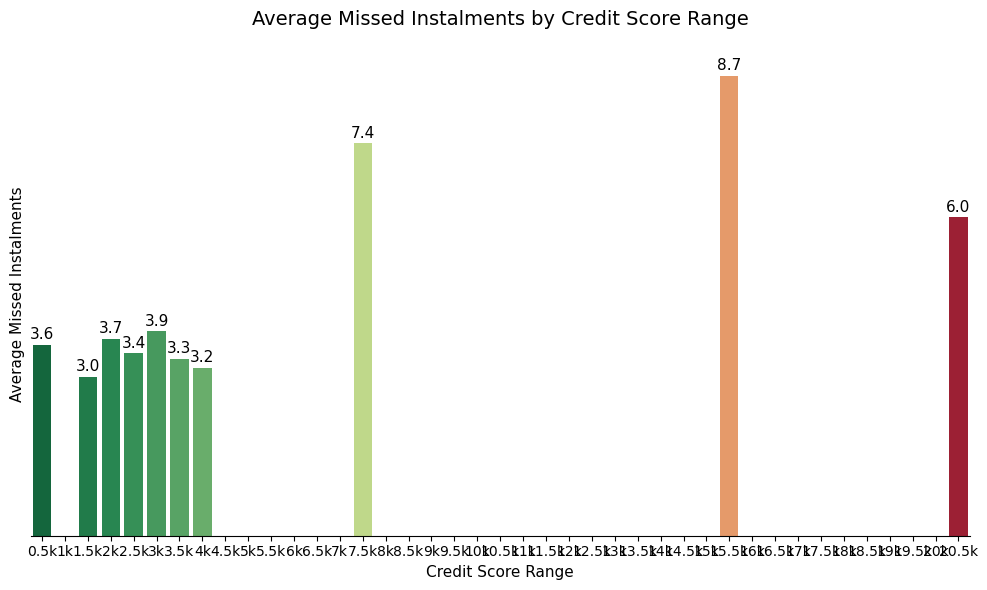

In [34]:
bins = range(0, int(df['CreditScore'].max()) + 501, 500)
labels = [f'{b/1000:g}k' for b in bins[1:]] 
df['ScoreRange'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

score_risk = df.groupby('ScoreRange', observed=True)['MissedInstalments'].mean().reset_index()

# Visualization: Average Missed Instalments by Credit Score Range
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=score_risk, x='ScoreRange', y='MissedInstalments', palette='RdYlGn_r')

# remove top and right spines for cleaner look
sns.despine(left=True, bottom=False)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.05, 
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='normal')

plt.title('Average Missed Instalments by Credit Score Range', fontsize=14, pad=20)
plt.xlabel('Credit Score Range', fontsize=11)
plt.ylabel('Average Missed Instalments', fontsize=11)
plt.yticks([])

plt.tight_layout()
plt.show()

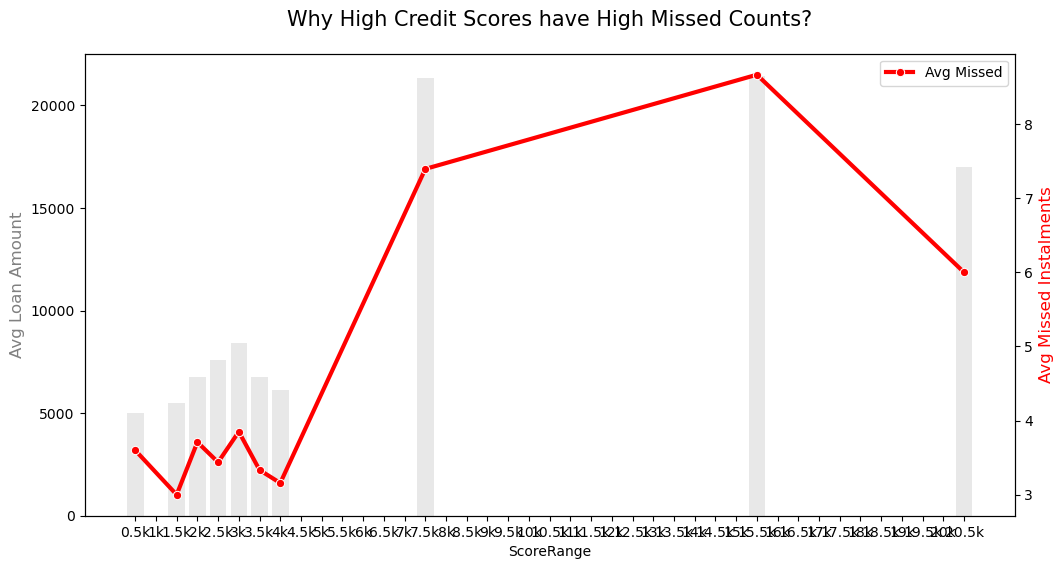

In [37]:
# 1. 데이터 준비 (이전 구간 설정 활용)
bins = range(0, int(df['CreditScore'].max()) + 501, 500)
labels = [f'{b/1000:g}k' for b in bins[1:]]
df['ScoreRange'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

# 2. 구간별 평균 연체, 금액, 기간 계산
analysis = df.groupby('ScoreRange', observed=True).agg({
    'MissedInstalments': 'mean',
    'AmountDisbursed': 'mean',
}).reset_index()

# 3. 시각화 (세 가지 지표 비교)
fig, ax1 = plt.subplots(figsize=(12, 6))

# 바 차트: 대출 금액 (배경)
sns.barplot(data=analysis, x='ScoreRange', y='AmountDisbursed', color='lightgray', alpha=0.5, ax=ax1)
ax1.set_ylabel('Avg Loan Amount', fontsize=12, color='gray')

# 꺽은선 그래프: 연체 횟수
ax2 = ax1.twinx()
sns.lineplot(data=analysis, x='ScoreRange', y='MissedInstalments', color='red', marker='o', linewidth=3, ax=ax2, label='Avg Missed')
ax2.set_ylabel('Avg Missed Instalments', fontsize=12, color='red')

plt.title('Why High Credit Scores have High Missed Counts?', fontsize=15, pad=20)
plt.show()

Through Corrleation between credit score and missed instalments, there is crucial effect to AI that Higher credit score has higher default possibility which is completely wrong as their Loan Amount is higher than less credit scores. So, need to create feature engineering to prevent miss reading.

[ Feature Engineering ]
# 1. Loan-to-Score Ratio (Credit Exposure relative to Score) : This metric evaluates how "excessively" a customer has borrowed compared to their creditworthiness. It helps identify high-credit individuals who may be over-leveraged.
df['Loan_to_Score_Ratio'] = df['AmountDisbursed'] / (df['CreditScore'] + 1)

# 2. Installment Burden (Repayment Pressure) : This represents the financial pressure per installment. By dividing the total disbursed amount by the loan term, we can estimate the customer's periodic cash flow strain.
df['Installment_Burden'] = df['AmountDisbursed'] / df['Term']

# 3. Relative Missed Installments (Product-Specific Risk Normalization) : This normalizes the number of missed installments within each product category. It accounts for the fact that longer-term products naturally have a higher probability of occasional misses, allowing the AI to identify outliers who miss payments significantly more than the "average" user of that specific product.
df['Relative_Missed'] = df.groupby('Product')['MissedInstalments'].transform(lambda x: (x - x.mean()) / x.std())

----------------------------------------------------------------------------------------------------------------------

D. Check correalation between Business types and default score
** Deteact risk per business type. ML can learn even client have good credit score, depends on amount of money, they cannot payback on time. -> "If the amount of loan is over certain amount, risk of default is increased"

It proves, to do accurate default prediction, AI has to consider not only credit score, but also other features such as business type, amount of loan, etc.

High credit score but missed instalments clients: 503


/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/2526589772.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_prime, y='BusinessType',


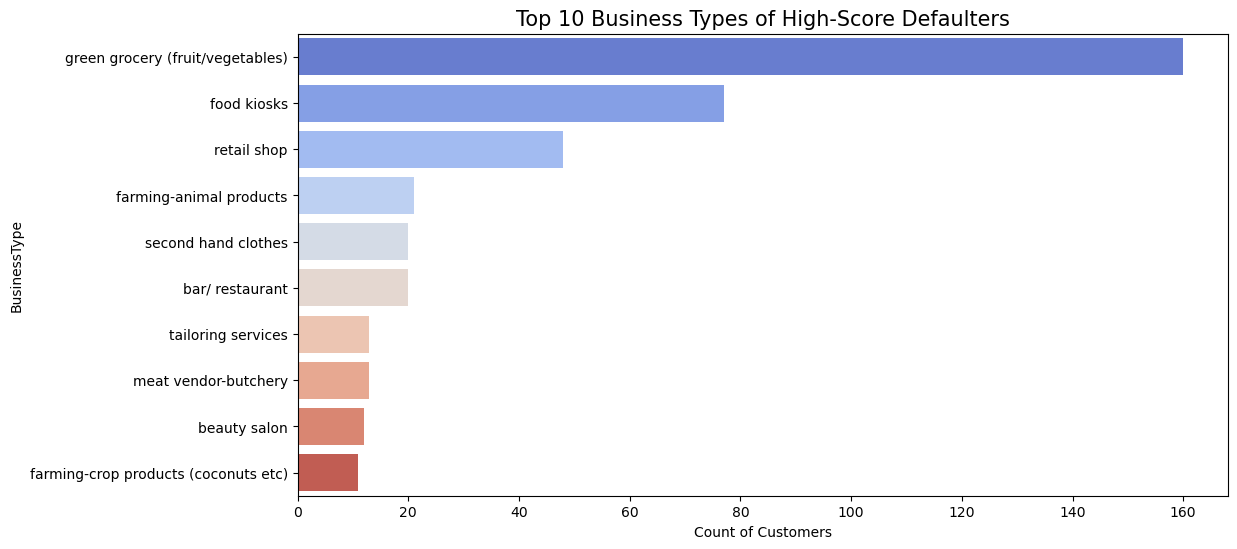

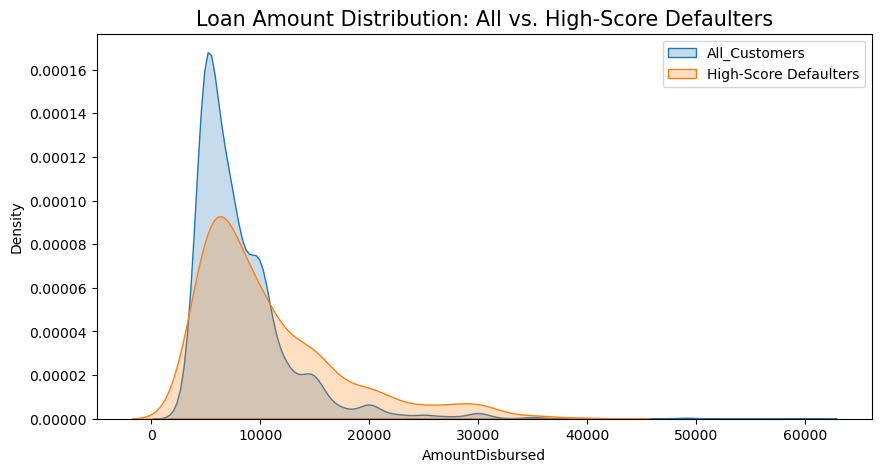

In [35]:
# High Credit Score but High Missed Instalments Analysis
high_score_threshold = df['CreditScore'].quantile(0.75)  # Top 25% credit score
high_missed_threshold = df['MissedInstalments'].mean()   # Average missed instalments

high_risk_prime = df[(df['CreditScore'] >= high_score_threshold) & 
                     (df['MissedInstalments'] > high_missed_threshold)].copy()

print(f"High credit score but missed instalments clients: {len(high_risk_prime)}")

# Visualization their business types
plt.figure(figsize=(12, 6))
sns.countplot(data=high_risk_prime, y='BusinessType', 
              order=high_risk_prime['BusinessType'].value_counts().iloc[:10].index,
              palette='coolwarm')

plt.title('Top 10 Business Types of High-Score Defaulters', fontsize=15)
plt.xlabel('Count of Customers')
plt.show()

# Visualization: Loan Amount Distribution - All vs. High-Score Defaulters
plt.figure(figsize=(10, 5))
sns.kdeplot(data['AmountDisbursed'], label='All_Customers', fill=True)
sns.kdeplot(high_risk_prime['AmountDisbursed'], label='High-Score Defaulters', fill=True)

plt.title('Loan Amount Distribution: All vs. High-Score Defaulters', fontsize=15)
plt.legend()
plt.show()

--- Industry Summary Statistics ---
                                  Avg_Loan_Amount  Avg_Repayment_Days  \
Industry                                                                
education                            20000.000000           77.500000   
transportation                       10119.047619           54.404762   
wholesale & retail trade              9324.324324           36.918919   
manufacturing                         9285.714286           36.142857   
fashion & beauty products             8923.566879           43.184713   
agriculture                           8369.230769           45.892308   
food & hospitality                    8288.190683           43.643554   
automobile services                   8222.222222           23.333333   
business & information                8142.857143           53.285714   
natural resources/environmental       7837.837838           34.837838   
agriculture, forestry & fishing       7814.814815           37.370370   
real estate & h

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/236253819.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Industry', y='AmountDisbursed', palette='Set2')
/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/236253819.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)


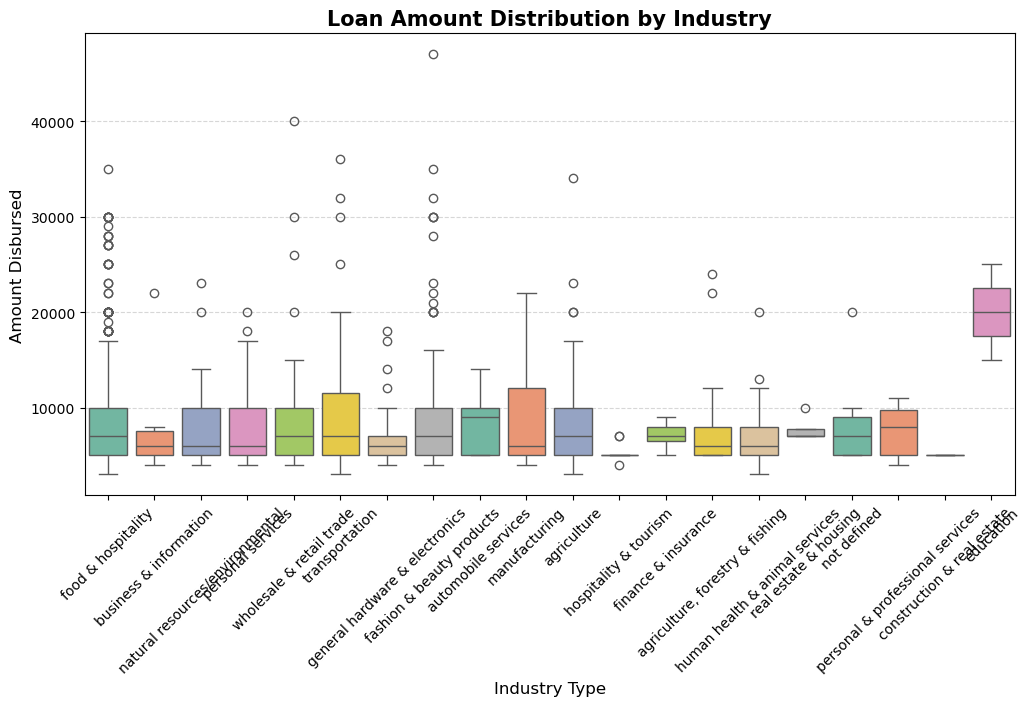

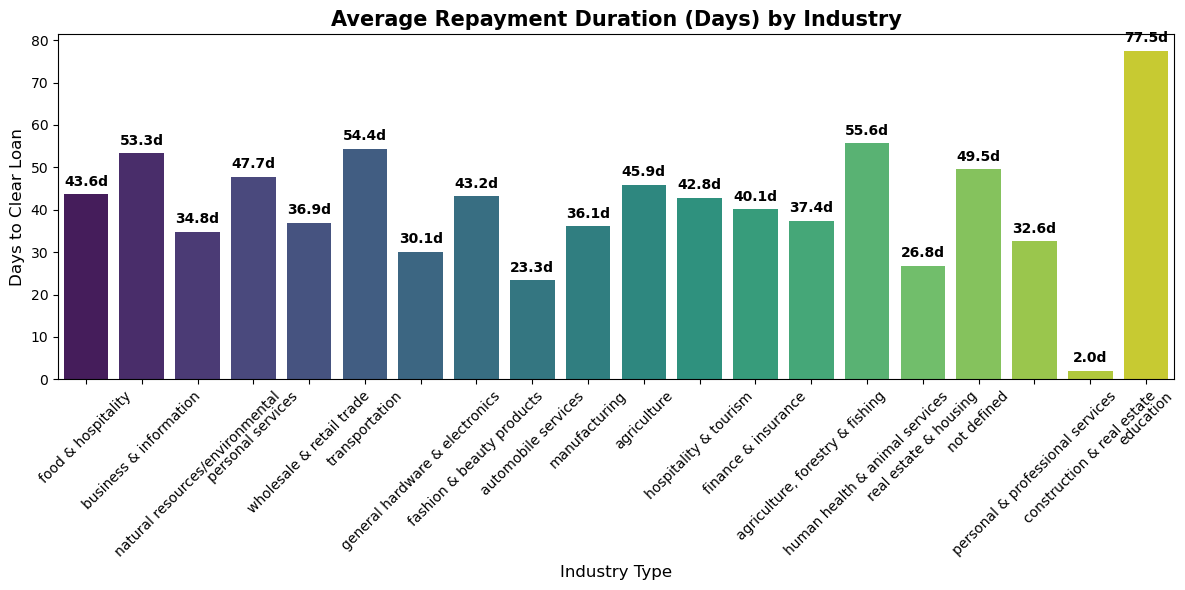

In [45]:
# 1. Feature Engineering: Calculating Repayment Duration
# Converting to datetime to ensure accurate calculation
df['BorrowDate'] = pd.to_datetime(df['BorrowDate'])
df['ClearDate'] = pd.to_datetime(df['ClearDate'])

# Repayment duration in days
df['RepaymentDuration'] = (df['ClearDate'] - df['BorrowDate']).dt.days

# 2. Aggregating Statistics by Industry
# We analyze the average loan size, repayment speed, and total volume
industry_summary = df.groupby('Industry').agg({
    'AmountDisbursed': 'mean',
    'RepaymentDuration': 'mean',
    'LoanId': 'count'
}).rename(columns={
    'AmountDisbursed': 'Avg_Loan_Amount',
    'RepaymentDuration': 'Avg_Repayment_Days',
    'LoanId': 'Total_Loan_Count'
}).sort_values(by='Avg_Loan_Amount', ascending=False)

print("--- Industry Summary Statistics ---")
print(industry_summary)

# 3. Visualization 1: Loan Amount Distribution by Industry
# Boxplot helps identify the spread and potential outliers in loan sizes per industry
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Industry', y='AmountDisbursed', palette='Set2')
plt.xticks(rotation=45)
plt.title('Loan Amount Distribution by Industry', fontsize=15, fontweight='bold')
plt.xlabel('Industry Type', fontsize=12)
plt.ylabel('Amount Disbursed', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig('industry_loan_amount_distribution.png', dpi=300, bbox_inches='tight')

# 4. Visualization 2: Average Repayment Duration by Industry
# Bar chart to compare how long each industry takes to clear their debt
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)

# Adding value labels on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}d', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.title('Average Repayment Duration (Days) by Industry', fontsize=15, fontweight='bold')
plt.xlabel('Industry Type', fontsize=12)
plt.ylabel('Days to Clear Loan', fontsize=12)

plt.tight_layout()
plt.savefig('industry_repayment_duration.png', dpi=300, bbox_inches='tight')
plt.show()

. 업종별 대출 한도의 적정성
Boxplot에서 특정 업종의 상자 크기가 크거나 이상치가 많다면, 해당 업종 내에서도 고객별 매출 규모 차이가 크다는 것을 의미합니다.

특정 업종의 평균 대출액이 낮음에도 불구하고 연체율이 높다면, 대출 한도를 더 낮추거나 상환 주기를 조정해야 할 신호일 수 있습니다.

2. 상환 소요 기간(Repayment Duration)
실제 상환 기간이 상품 설계상의 기간(예: 5주, 10주)보다 유독 긴 업종이 있는지 확인하세요.

만약 특정 업종의 상환 기간이 다른 업종보다 길다면, 해당 업종의 현금 흐름 주기에 맞춰 **거치 기간(Grace Period)**을 주거나 상환 횟수를 분산하는 상품 설계가 필요합니다.

3. 수익성 대 리스크
대출 규모는 크지만 상환 기간이 너무 긴 업종은 자금 회전율을 낮출 수 있습니다. 반대로 대출 규모는 작지만 회전이 빠른 업종은 운영 비용 대비 효율적인 수익원이 될 수 있습니다.

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/3401517482.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')


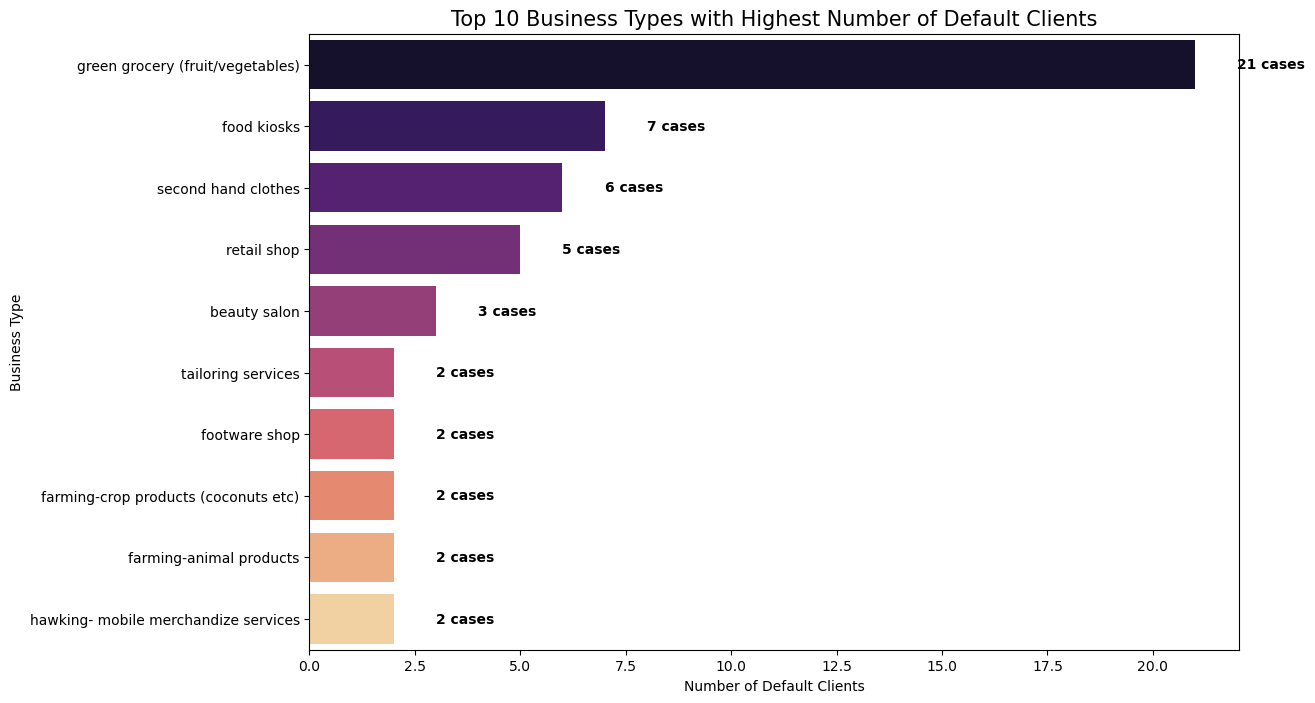

                            BusinessType  Total_Clients  Default_Clients  \
22      green grocery (fruit/vegetables)            492               21   
20                           food kiosks            212                7   
42                   second hand clothes             72                6   
40                           retail shop            139                5   
5                           beauty salon             41                3   
43                    tailoring services             33                2   
21                         footware shop             19                2   
18  farming-crop products (coconuts etc)             30                2   
17               farming-animal products             58                2   
23  hawking- mobile merchandize services             22                2   

    Default_Rate_%  
22        4.268293  
20        3.301887  
42        8.333333  
40        3.597122  
5         7.317073  
43        6.060606  
21       10.5263

In [41]:
# 1. Assuming 'Default' column is already created by your teammate
# If not, we use the logic: (df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)
if 'Default' not in df.columns:
    df['Default'] = ((df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)

# 2. Group by BusinessType to get total and default counts
business_analysis = df.groupby('BusinessType').agg(
    Total_Clients=('LoanId', 'count'),
    Default_Clients=('Default', 'sum')
).reset_index()

# 3. Calculate Default Rate (%) for better context
business_analysis['Default_Rate_%'] = (business_analysis['Default_Clients'] / business_analysis['Total_Clients']) * 100
business_analysis = business_analysis.sort_values(by='Default_Clients', ascending=False)

# 4. Visualize the top 10 Business Types with most Defaulters
plt.figure(figsize=(12, 8))
sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')

# Add value labels
for i, val in enumerate(business_analysis.head(10)['Default_Clients']):
    plt.text(val + 1, i, f'{int(val)} cases', va='center', fontweight='bold')

plt.title('Top 10 Business Types with Highest Number of Default Clients', fontsize=15)
plt.xlabel('Number of Default Clients')
plt.ylabel('Business Type')
plt.show()

# Display the table
print(business_analysis[['BusinessType', 'Total_Clients', 'Default_Clients', 'Default_Rate_%']].head(10))

## Details : which product / amount disbursed that default green grocery business type has

/var/folders/8q/fl3wttwd7c7d86ktpbtwn_0m0000gn/T/ipykernel_69503/396942772.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grocery_stats, x='Product', y='Total_Amount', palette='Greens_r', ax=ax1)


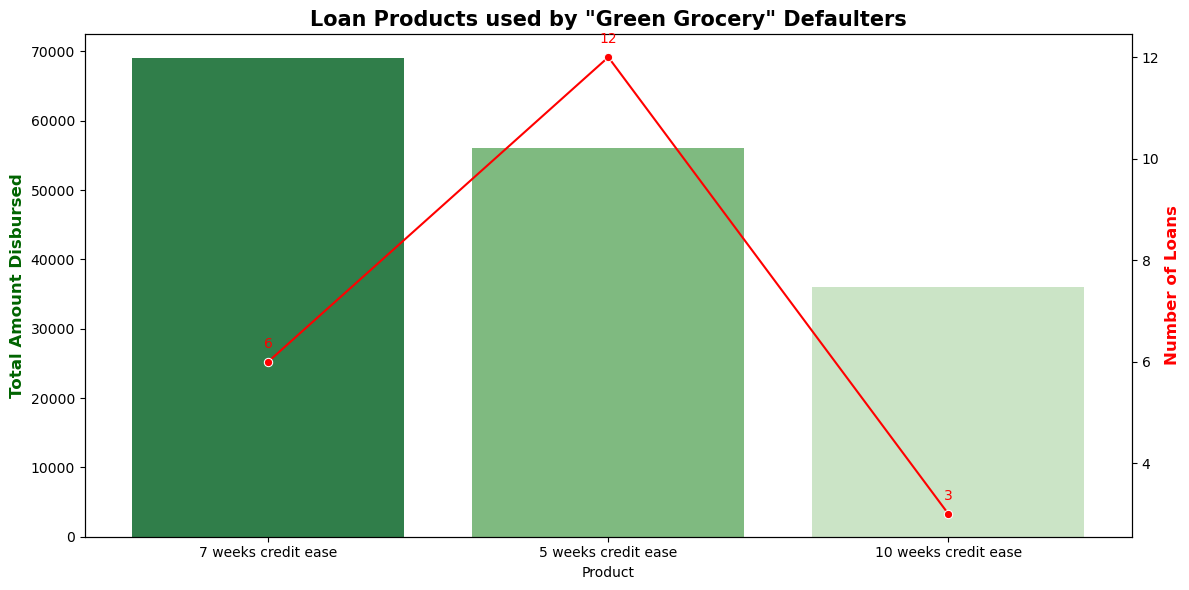

--- Statistics for Green Grocery (Defaulters Only) ---
                Product  Loan_Count  Total_Amount    Avg_Amount
0   7 weeks credit ease           6         69000  11500.000000
1   5 weeks credit ease          12         56000   4666.666667
2  10 weeks credit ease           3         36000  12000.000000


In [48]:
# 1. Filter for the specific business type (handling potential naming variations)
# We search for "green grocery" or "fruit" within the BusinessType column
target_business = df[df['BusinessType'].str.contains('green grocery|fruit|vegetable', case=False, na=False)]

# 2. Focus on Defaulted clients within this business
grocery_defaults = target_business[target_business['Default'] == 1].copy()

# 3. Aggregate data by Product
grocery_stats = grocery_defaults.groupby('Product').agg(
    Loan_Count=('LoanId', 'count'),
    Total_Amount=('AmountDisbursed', 'sum'),
    Avg_Amount=('AmountDisbursed', 'mean')
).sort_values(by='Total_Amount', ascending=False).reset_index()

# 4. Visualization: Product Distribution for Green Grocery Defaulters
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Total Amount Disbursed
sns.barplot(data=grocery_stats, x='Product', y='Total_Amount', palette='Greens_r', ax=ax1)
ax1.set_ylabel('Total Amount Disbursed', fontsize=12, fontweight='bold', color='darkgreen')
ax1.set_title('Loan Products used by "Green Grocery" Defaulters', fontsize=15, fontweight='bold')

# Line chart for Loan Count (Dual Axis)
ax2 = ax1.twinx()
sns.lineplot(data=grocery_stats, x='Product', y='Loan_Count', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Number of Loans', fontsize=12, fontweight='bold', color='red')

# Add labels
for i, txt in enumerate(grocery_stats['Loan_Count']):
    ax2.annotate(txt, (grocery_stats['Product'][i], grocery_stats['Loan_Count'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.tight_layout()
plt.savefig('green_grocery_default_analysis.png', dpi=300)
plt.show()

print("--- Statistics for Green Grocery (Defaulters Only) ---")
print(grocery_stats)

[ Feature Engineering(2) ]

1. Score Deviation by Business Type
This feature measures how a customer’s credit score compares to the average score of their specific industry.

Logic: A score of 3,000 in a "High-Risk" industry might be more impressive than the same score in a "Low-Risk" industry. This normalizes creditworthiness within the business context.

Code : # Ratio of individual score to industry average
df['Score_vs_Business_Avg'] = df['CreditScore'] / df.groupby('BusinessType')['CreditScore'].transform('mean')

2. Industry Risk Weight (Target Encoding)
This transforms the categorical BusinessType into a numerical risk value based on historical default rates.

Logic: It allows the AI to recognize that certain sectors (like Green Grocery) have a baseline systemic risk regardless of individual scores.

Code : # Map the average default rate of each business type back to the dataframe
business_default_map = df.groupby('BusinessType')['Default'].mean()
df['Business_Risk_Index'] = df['BusinessType'].map(business_default_map)

3. High-Score Paradox Flag (Anomalous Risk)
This creates a binary indicator for the specific "High-Score but High-Missed" group we identified earlier.

Logic: Traditional models often assume "Higher Score = Lower Risk." This flag explicitly teaches the AI about the exception: "High Score + High Debt/Missed = High Risk."

Code : score_q3 = df['CreditScore'].quantile(0.75)
missed_mean = df['MissedInstalments'].mean()

# Flag: 1 if high score but high missed instalments, else 0
df['Is_High_Score_Anomaly'] = ((df['CreditScore'] >= score_q3) & 
                               (df['MissedInstalments'] > missed_mean)).astype(int)